# Adding exponential mass loss/growth

You can always modify the mass of particles between calls to `sim.integrate`.  However, if you want to apply the mass/loss growth every timestep *within* calls to `sim.integrate`, you should use this.

We begin by setting up a system with 3 planets.

In [1]:
import rebound
import reboundx
import numpy as np

M0 = 1. # initial mass of star

def makesim():
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2 # use units of AU, yrs and solar masses

    sim.add(m=M0)
    sim.add(a=1.)
    sim.add(a=2.)
    sim.add(a=3.)
    sim.move_to_com()
    return sim

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


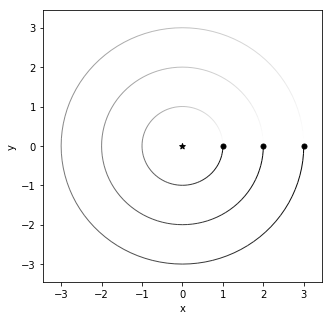

In [2]:
%matplotlib inline
sim = makesim()
ps = sim.particles
fig = rebound.OrbitPlot(sim)

We now add mass loss through REBOUNDx:

In [3]:
rebx = reboundx.Extras(sim)
modifymass = rebx.create_operator("modify_mass")
rebx.add_operator(modifymass)

Now we set the e-folding mass loss/growth rate.  

**Positive timescales give growth, negative timescales loss.**

Here we have the star lose mass with an e-folding timescale of $10^4$ yrs.

In [4]:
ps[0].params["tau_mass"] = -1.e4

Now we integrate for one e-folding timescale, and plot the resulting system:

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


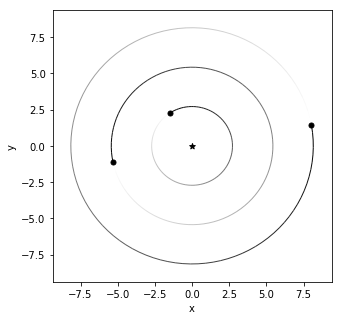

In [5]:
Nout = 1000
mass = np.zeros(Nout)
times = np.linspace(0., 1.e4, Nout)

for i, time in enumerate(times):
    sim.integrate(time)
    mass[i] = sim.particles[0].m
    
fig = rebound.OrbitPlot(sim, trails=True)

We see that after the mass of the star has decayed by a factor of `e`, the scale of the system has expanded by the corresponding factor, as one would expect.  If we plot the mass of the star vs time, compared to an exponential decay, the two overlap.

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


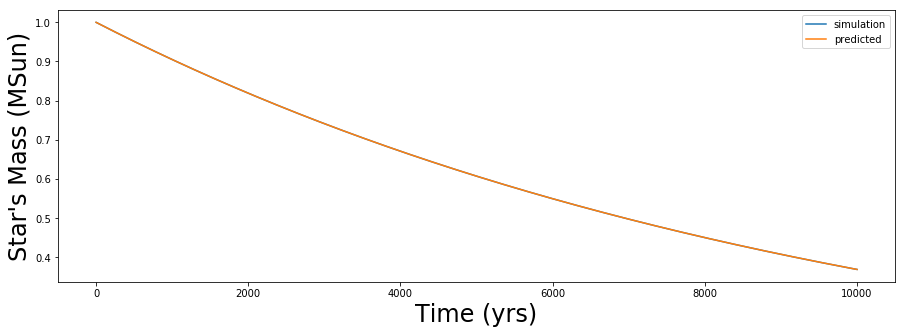

In [6]:
pred = M0*np.e**(times/ps[0].params["tau_mass"])
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(111)
ax.plot(times,mass, label='simulation')
ax.plot(times,pred, label='predicted')
ax.set_xlabel("Time (yrs)", fontsize=24)
ax.set_ylabel("Star's Mass (MSun)", fontsize=24)
plt.legend()

# Manually Adding Operator Steps

By default, `rebx.add_operator` will add half timesteps of the passed operator before and after the main REBOUND timestep. You can also specify individual operator steps manually, using the `dt_fraction` (which specifies the fraction of a timestep (`sim.dt`) the operator should act) and `timing` ("pre" or "post", which specifies whether it gets added before or after the main REBOUND timestep) parameters. For example for a simple first-order scheme where the operator acts for a full timestep after the main step:

In [7]:
sim = makesim()
rebx = reboundx.Extras(sim)
modifymass = rebx.create_operator("modify_mass")
rebx.add_operator(modifymass, dt_fraction=1., timing="post", name="fulltimestepafter")

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


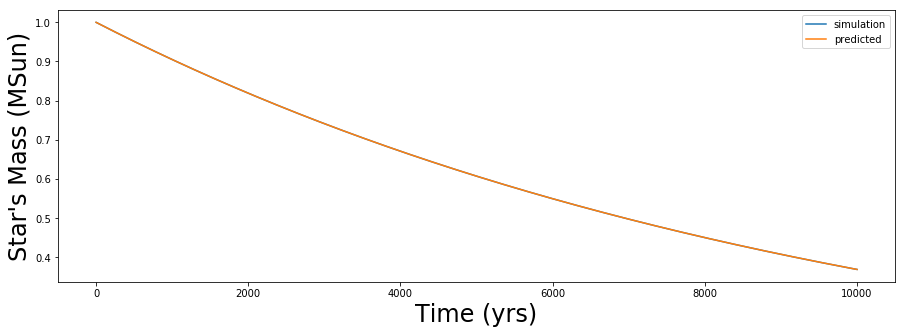

In [8]:
sim.particles[0].params["tau_mass"] = -1.e4
Nout = 1000
mass = np.zeros(Nout)
times = np.linspace(0., 1.e4, Nout)

for i, time in enumerate(times):
    sim.integrate(time)
    mass[i] = sim.particles[0].m
    
pred = M0*np.e**(times/ps[0].params["tau_mass"])
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(111)
ax.plot(times,mass, label='simulation')
ax.plot(times,pred, label='predicted')
ax.set_xlabel("Time (yrs)", fontsize=24)
ax.set_ylabel("Star's Mass (MSun)", fontsize=24)
plt.legend()